In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from itertools import combinations, product

In [12]:
df = pd.read_csv("cleaned_data.csv")

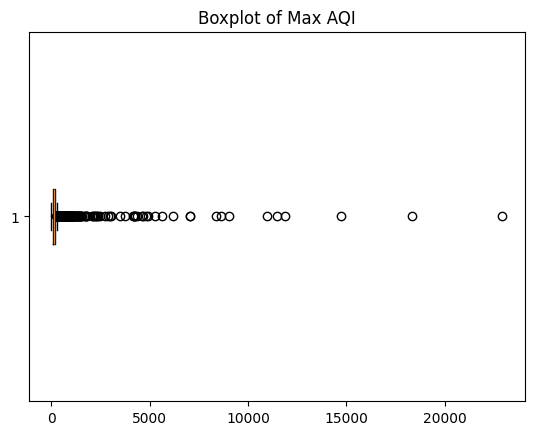

In [4]:
plt.boxplot(df['Max AQI'], vert=False)
plt.title('Boxplot of Max AQI')
plt.show()

Exploratory analysis revealed that annual maximum AQI shows a right-tailed distribution with extreme outliers. Log transformation reduced skewness and produced an approximately normal distribution. 

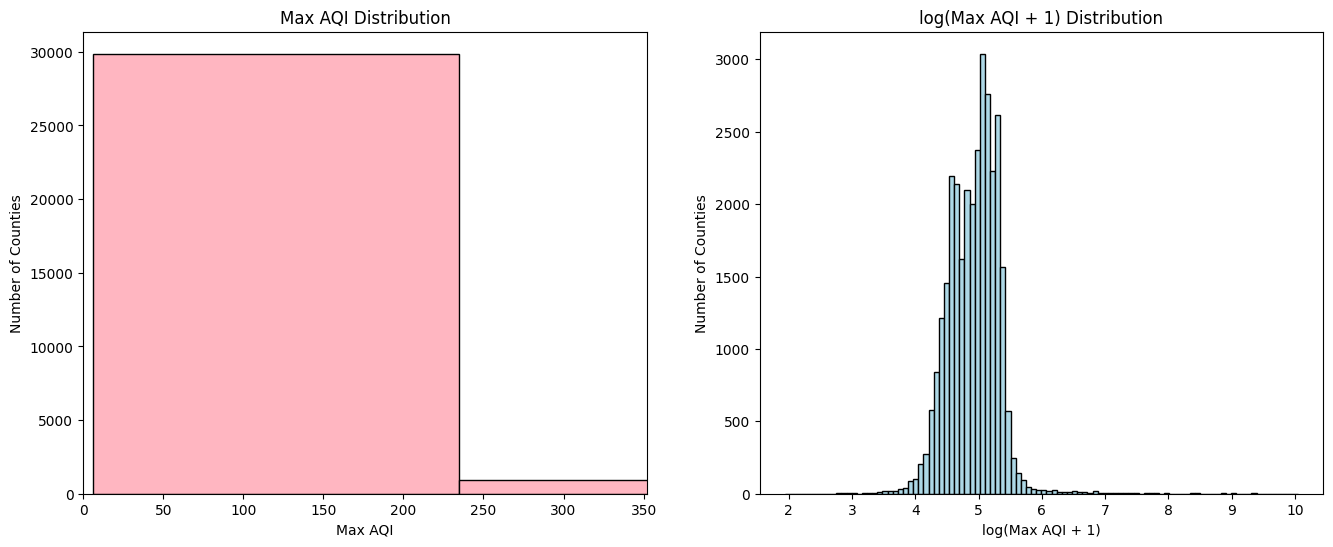

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].hist(df['Max AQI'], bins=100, color='lightpink', edgecolor='black')
axs[0].set_title('Max AQI Distribution')
axs[0].set_xlabel('Max AQI')
axs[0].set_ylabel('Number of Counties')
axs[0].set_xlim(0, df['Max AQI'].quantile(0.99))

axs[1].hist(np.log1p(df['Max AQI']), bins=100, color='lightblue', edgecolor='black')
axs[1].set_title('log(Max AQI + 1) Distribution')
axs[1].set_xlabel('log(Max AQI + 1)')
axs[1].set_ylabel('Number of Counties')
plt.show()

In [6]:
print("Mean Max AQI:", df['Max AQI'].min())
print("Mean Max AQI:", df['Max AQI'].max())
print("Mean Max AQI:", df['Max AQI'].mean())
print("Mean Max AQI:", df['Max AQI'].std())

Mean Max AQI: 6
Mean Max AQI: 22897
Mean Max AQI: 154.28036267423852
Mean Max AQI: 272.38879647728993


To predict next year's mximum air quality index, we construct the target variable by shifting annual maximum AQI forward by one year within each State–County time series. This aligns features from year t with the maximum AQI observed in year t+1, ensuring a valid prediction setup.

In [13]:
df = df.sort_values(['State', 'County', 'Year']).reset_index(drop=True)
df['next_year_max_aqi'] = df.groupby(['State', 'County'])['Max AQI'].shift(-1)

### Feature construction

We construct normalized and ratio-based features from the raw annual air quality statistics. Percentage-based features remove scale effects due to differences in monitoring coverage and county size, while ratio-based and log-transformed features summarize distributional shape and tail behavior. These transformations are deterministic and do not introduce additional information beyond the original dataset; they are used to establish a normalized baseline representation for modeling.

In [21]:
days_with_aqi = df["Days with AQI"].replace(0, np.nan)

# log transform of current year max AQI
df["log_max_aqi"] = np.log1p(df["Max AQI"])

# Percent of days by AQI category
df["pct_good_days"] = df["Good Days"] / days_with_aqi
df["pct_moderate_days"] = df["Moderate Days"] / days_with_aqi
df["pct_unhealthy_for_sensitive_groups_days"] = (
    df["Unhealthy for Sensitive Groups Days"] / days_with_aqi
)
df["pct_unhealthy_days"] = df["Unhealthy Days"] / days_with_aqi
df["pct_very_unhealthy_days"] = df["Very Unhealthy Days"] / days_with_aqi
df["pct_hazardous_days"] = df["Hazardous Days"] / days_with_aqi

# Combined unhealthy exposure
df["pct_unhealthy_plus"] = (
    df["Unhealthy for Sensitive Groups Days"]
    + df["Unhealthy Days"]
    + df["Very Unhealthy Days"]
    + df["Hazardous Days"]
) / days_with_aqi

# Distribution shape ratios
df["max_to_median"] = df["Max AQI"] / df["Median AQI"].replace(0, np.nan)

### Baseline 1 — XGBoost

As a reference point, we first evaluate a baseline model using the original annual air quality summary features without normalization.

We use XGBoost for this baseline because it is well-suited to structured tabular data with heterogeneous feature scales and non-linear interactions. Annual air quality metrics exhibit skewed distributions and extreme values. These properties make XGBoost an appropriate baseline model for predicting next year extreme AQI.

In [22]:
df = df.dropna(subset=['next_year_max_aqi'])

df = df[df['Year'] < 2025].copy()

train_df = df[df['Year'] <= 2023].copy()
test_df = df[df['Year'] == 2024].copy()

feature_cols = [
    'Days with AQI',
    'Good Days', 
    'Moderate Days',
    'Unhealthy for Sensitive Groups Days',
    'Unhealthy Days',
    'Very Unhealthy Days',
    'Hazardous Days',
    '90th Percentile AQI',
    'Median AQI',
    'Days CO',
    'Days NO2',
    'Days Ozone',
    'Days PM2.5',
    'Days PM10'
]
    
X_train = train_df[feature_cols]
y_train = train_df['next_year_max_aqi']
    
X_test = test_df[feature_cols]
y_test = test_df['next_year_max_aqi']

model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1, 
    max_depth=6, 
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print("\nTrain Set:")
print(f"MAE:{mean_absolute_error(y_train, train_pred):.2f}")
print(f"RMSE: {root_mean_squared_error(y_train, train_pred):.2f}")
print(f"R²: {r2_score(y_train, train_pred):.4f}")

print("\nTest Set:")
print(f"MAE:{mean_absolute_error(y_test, test_pred):.2f}")
print(f"RMSE:{root_mean_squared_error(y_test, test_pred):.2f}")
print(f"R²:{r2_score(y_test, test_pred):.4f}")



Train Set:
MAE:28.07
RMSE: 58.42
R²: 0.9563

Test Set:
MAE:35.44
RMSE:83.58
R²:0.4100


### Baseline 2 - Normalized / Derived Features

Motivated by the heavy-tailed distribution of maximum AQI, we evaluate a model using normalized and ratio-based features. Despite improved distributional properties, this transformation did not improve predictive performance relative to the raw-feature baseline.

In [23]:
feature_cols = [
    'log_max_aqi',
    'pct_good_days',
    'pct_moderate_days',
    'pct_unhealthy_for_sensitive_groups_days',
    'pct_unhealthy_days',
    'pct_very_unhealthy_days',
    'pct_hazardous_days',
    'pct_unhealthy_plus',
    'max_to_median'
]

X_train = train_df[feature_cols]
y_train = train_df['next_year_max_aqi'].astype(float)

X_test  = test_df[feature_cols]
y_test  = test_df['next_year_max_aqi'].astype(float)

y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)

model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1, 
    max_depth=6, 
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train_log)

# predictions in log space
train_pred_log = model.predict(X_train)
test_pred_log  = model.predict(X_test)

# inverse back to AQI units
train_pred = np.expm1(train_pred_log)
test_pred  = np.expm1(test_pred_log)

print("\nTRAIN SET (evaluated in ORIGINAL AQI units):")
print(f"  MAE:  {mean_absolute_error(y_train, train_pred):.2f}")
print(f"  RMSE: {root_mean_squared_error(y_train, train_pred):.2f}")
print(f"  R²:   {r2_score(y_train, train_pred):.4f}")

print("\nTEST SET (evaluated in ORIGINAL AQI units):")
print(f"  MAE:  {mean_absolute_error(y_test, test_pred):.2f}")
print(f"  RMSE: {root_mean_squared_error(y_test, test_pred):.2f}")
print(f"  R²:   {r2_score(y_test, test_pred):.4f}")



TRAIN SET (evaluated in ORIGINAL AQI units):
  MAE:  28.19
  RMSE: 114.54
  R²:   0.8320

TEST SET (evaluated in ORIGINAL AQI units):
  MAE:  33.69
  RMSE: 95.82
  R²:   0.2245


### Geographic Features

We evaluate whether explicit geographic identifiers improve performance by capturing regional information.

In [24]:
df_geo = df.dropna(subset=["next_year_max_aqi"]).copy()
df_geo = df_geo[df_geo["Year"] < 2025].copy()

df_geo["State"] = df_geo["State"].astype("category")
df_geo["County"] = df_geo["County"].astype("category")

train_df = df_geo[df_geo["Year"] <= 2023].copy()
test_df  = df_geo[df_geo["Year"] == 2024].copy()

base_feature_cols = [
    "Days with AQI",
    "Good Days",
    "Moderate Days",
    "Unhealthy for Sensitive Groups Days",
    "Unhealthy Days",
    "Very Unhealthy Days",
    "Hazardous Days",
    "90th Percentile AQI",
    "Median AQI",
    "Days CO",
    "Days NO2",
    "Days Ozone",
    "Days PM2.5",
    "Days PM10",
    'State',
    'County'
]

X_train = train_df[feature_cols]
y_train = train_df["next_year_max_aqi"].astype(float)

X_test = test_df[feature_cols]
y_test = test_df["next_year_max_aqi"].astype(float)

model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    tree_method="hist",
    enable_categorical=True
)

model.fit(X_train, y_train)

train_pred = model.predict(X_train)
test_pred  = model.predict(X_test)

print("\nTrain Set (+ State+County):")
print(f"MAE:  {mean_absolute_error(y_train, train_pred):.2f}")
print(f"RMSE: {root_mean_squared_error(y_train, train_pred):.2f}")
print(f"R²:   {r2_score(y_train, train_pred):.4f}")

print("\nTest Set (+ State+County):")
print(f"MAE:  {mean_absolute_error(y_test, test_pred):.2f}")
print(f"RMSE: {root_mean_squared_error(y_test, test_pred):.2f}")
print(f"R²:   {r2_score(y_test, test_pred):.4f}")


Train Set (+ State+County):
MAE:  28.66
RMSE: 67.87
R²:   0.9410

Test Set (+ State+County):
MAE:  35.58
RMSE: 88.47
R²:   0.3389


Including State and County as categorical features increased training performance but reduced test-set performance. This indicates overfitting to location-specific patterns and suggests that static geographic identifiers do not generalize well for predicting next year extreme AQI.

### Historical Lag Features

We evaluate whether including recent air quality history improves prediction by capturing temporal persistence in extreme AQI. Lagged values from the previous year are tested.

In [32]:
df_hist = df.copy()

df_hist = df_hist.sort_values(["State", "County", "Year"]).reset_index(drop=True)

g = df_hist.groupby(["State", "County"], group_keys=False)

df_hist["log_max_aqi_lag1"] = g["log_max_aqi"].shift(1)
df_hist["log_max_aqi_lag2"] = g["log_max_aqi"].shift(2)

df_hist["log_max_aqi_roll3_max"]  = g["log_max_aqi"].shift(1).rolling(3, min_periods=3).max()
df_hist["log_max_aqi_roll3_mean"] = g["log_max_aqi"].shift(1).rolling(3, min_periods=3).mean()

df_hist["max_aqi_trend"] = df_hist["log_max_aqi_lag1"] - df_hist["log_max_aqi_lag2"]

df_hist["pm25_pct_lag1"] = g["pct_days_pm2.5"].shift(1)

history_cols = [
    "log_max_aqi_lag1",
    "log_max_aqi_lag2",
    "log_max_aqi_roll3_max",
    "log_max_aqi_roll3_mean",
    "max_aqi_trend",
    "pm25_pct_lag1",
]

has_history = df_hist[history_cols].notna().all(axis=1)

df_hist = df_hist.dropna(subset=["next_year_max_aqi"]).copy()
df_hist = df_hist[df_hist["Year"] < 2025].copy()

train_mask = (df_hist["Year"] <= 2023) & has_history.loc[df_hist.index]
test_mask  = (df_hist["Year"] == 2024) & has_history.loc[df_hist.index]

features_with_lag = [
    # raw annual data
    "Days with AQI",
    "Good Days",
    "Moderate Days",
    "Unhealthy for Sensitive Groups Days",
    "Unhealthy Days",
    "Very Unhealthy Days",
    "Hazardous Days",
    "90th Percentile AQI",
    "Median AQI",
    "Days CO",
    "Days NO2",
    "Days Ozone",
    "Days PM2.5",
    "Days PM10",

    # history features
] + history_cols

X_train = df_hist.loc[train_mask, features_with_lag].copy()
X_test  = df_hist.loc[test_mask,  features_with_lag].copy()

y_train = df_hist.loc[train_mask, "next_year_max_aqi"].astype(float)
y_test  = df_hist.loc[test_mask,  "next_year_max_aqi"].astype(float)

y_train_log = np.log1p(y_train)

model = XGBRegressor(
    n_estimators=600,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
)

model.fit(X_train, y_train_log)

train_pred_log = model.predict(X_train)
test_pred_log  = model.predict(X_test)

train_pred = np.expm1(train_pred_log)
test_pred  = np.expm1(test_pred_log)

print("\nTrain Set (+ Lag/History):")
print(f"MAE:  {mean_absolute_error(y_train, train_pred):.2f}")
print(f"RMSE: {root_mean_squared_error(y_train, train_pred):.2f}")
print(f"R²:   {r2_score(y_train, train_pred):.4f}")

print("\nTest Set (+ Lag/History):")
print(f"MAE:  {mean_absolute_error(y_test, test_pred):.2f}")
print(f"RMSE: {root_mean_squared_error(y_test, test_pred):.2f}")
print(f"R²:   {r2_score(y_test, test_pred):.4f}")


Train Set (+ Lag/History):
MAE:  25.53
RMSE: 112.30
R²:   0.8552

Test Set (+ Lag/History):
MAE:  36.85
RMSE: 101.21
R²:   0.1405


Including lagged and rolling historical air quality features substantially improved training performance but degraded test-set performance. This indicates overfitting to short-term historical patterns and suggests that year-to-year persistence in extreme AQI is weak. Consistent with prior results, next year AQI extremes appear to be driven by episodic events rather than stable temporal trends.


###  Model Tuning 

After establishing baseline performance and evaluating several feature extensions, we focus on improving generalization through model tuning rather than adding additional features. In this step, we tune XGBoost hyperparameters with an emphasis on controlling model complexity, using shallower trees and stronger regularization to reduce overfitting.


In [38]:
df_tune = df.dropna(subset=["next_year_max_aqi"]).copy()
df_tune = df_tune[df_tune["Year"] < 2025].copy()

train_df = df_tune[df_tune["Year"] <= 2023].copy()
test_df  = df_tune[df_tune["Year"] == 2024].copy()

feature_cols = [
    "Days with AQI",
    "Good Days",
    "Moderate Days",
    "Unhealthy for Sensitive Groups Days",
    "Unhealthy Days",
    "Very Unhealthy Days",
    "Hazardous Days",
    "90th Percentile AQI",
    "Median AQI",
    "Days CO",
    "Days NO2",
    "Days Ozone",
    "Days PM2.5",
    "Days PM10",
]

X_train = train_df[feature_cols]
y_train = train_df["next_year_max_aqi"].astype(float)

X_test  = test_df[feature_cols]
y_test  = test_df["next_year_max_aqi"].astype(float)

base_params = dict(
    objective="reg:squarederror",
    tree_method="hist",
    n_jobs=2,
    random_state=42,
)

grid = dict(
    n_estimators=[280, 320, 360, 420],
    max_depth=[4],
    min_child_weight=[6.0, 8.0, 10.0],
    colsample_bytree=[0.6, 0.7, 0.8],
    subsample=[0.8],
    learning_rate=[0.05],
    reg_alpha=[0.3],
    reg_lambda=[0.2, 0.35, 0.5, 0.65],
    gamma=[0.2, 0.3, 0.4],
)

keys = list(grid.keys())
values = [grid[k] for k in keys]
total = int(np.prod([len(v) for v in values]))

results = []
best_r2 = -np.inf
best_params = None

for i, combo in enumerate(product(*values), start=1):
    params = dict(zip(keys, combo))

    model = XGBRegressor(**base_params, **params)
    model.fit(X_train, y_train)

    pred = model.predict(X_test)

    r2 = r2_score(y_test, pred)
    rmse = root_mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)

    results.append({
        "iter": i,
        "r2": r2,
        "rmse": rmse,
        "mae": mae,
        **params
    })

    if r2 > best_r2:
        best_r2 = r2
        best_params = params

    if i % 25 == 0 or i == total:
        print(
            f"[{i:>4}/{total}] "
            f"R2={r2:.4f}  RMSE={rmse:.2f}  MAE={mae:.2f}"
        )

results_df = (
    pd.DataFrame(results)
    .sort_values("r2", ascending=False)
    .reset_index(drop=True)
)

print("\nBEST R2:", results_df.loc[0, "r2"])
print("BEST params:", {k: results_df.loc[0, k] for k in keys})

results_df.head(10)


[  25/432] R2=0.4998  RMSE=76.95  MAE=34.68
[  50/432] R2=0.5191  RMSE=75.46  MAE=34.56
[  75/432] R2=0.4745  RMSE=78.88  MAE=34.98
[ 100/432] R2=0.4240  RMSE=82.58  MAE=35.20
[ 125/432] R2=0.4980  RMSE=77.10  MAE=35.44
[ 150/432] R2=0.5525  RMSE=72.79  MAE=34.38
[ 175/432] R2=0.5148  RMSE=75.79  MAE=34.49
[ 200/432] R2=0.4949  RMSE=77.33  MAE=35.27
[ 225/432] R2=0.4303  RMSE=82.12  MAE=36.03
[ 250/432] R2=0.5338  RMSE=74.29  MAE=34.36
[ 275/432] R2=0.5825  RMSE=70.30  MAE=34.02
[ 300/432] R2=0.4612  RMSE=79.86  MAE=35.50
[ 325/432] R2=0.4253  RMSE=82.49  MAE=35.82
[ 350/432] R2=0.4945  RMSE=77.36  MAE=35.11
[ 375/432] R2=0.5188  RMSE=75.48  MAE=34.98
[ 400/432] R2=0.4426  RMSE=81.23  MAE=35.95
[ 425/432] R2=0.4125  RMSE=83.40  MAE=35.63
[ 432/432] R2=0.3505  RMSE=87.69  MAE=35.81

BEST R2: 0.5825385590526394
BEST params: {'n_estimators': np.int64(360), 'max_depth': np.int64(4), 'min_child_weight': np.float64(8.0), 'colsample_bytree': np.float64(0.7), 'subsample': np.float64(0.8), 'lea

,iter,r2,rmse,mae,n_estimators,max_depth,min_child_weight,colsample_bytree,subsample,learning_rate,reg_alpha,reg_lambda,gamma
0,274,0.582539,70.301418,34.021806,360,4,8.0,0.7,0.8,0.05,0.3,0.65,0.2
1,276,0.582539,70.301418,34.021806,360,4,8.0,0.7,0.8,0.05,0.3,0.65,0.4
2,275,0.582539,70.301418,34.021806,360,4,8.0,0.7,0.8,0.05,0.3,0.65,0.3
3,166,0.573951,71.020851,34.067304,320,4,8.0,0.7,0.8,0.05,0.3,0.65,0.2
4,167,0.573951,71.020851,34.067304,320,4,8.0,0.7,0.8,0.05,0.3,0.65,0.3
5,168,0.573951,71.020851,34.067304,320,4,8.0,0.7,0.8,0.05,0.3,0.65,0.4
6,382,0.573100,71.091672,34.456909,420,4,8.0,0.7,0.8,0.05,0.3,0.65,0.2
7,383,0.573100,71.091672,34.456909,420,4,8.0,0.7,0.8,0.05,0.3,0.65,0.3
8,384,0.573100,71.091672,34.456909,420,4,8.0,0.7,0.8,0.05,0.3,0.65,0.4
9,258,0.553850,72.676868,34.394737,360,4,8.0,0.6,0.8,0.05,0.3,0.35,0.4


In [39]:
model = XGBRegressor(
    n_estimators=360,
    learning_rate=0.05,
    max_depth=4, 
    min_child_weight=8.0,
    subsample=0.8,
    colsample_bytree=0.7,
    reg_alpha=0.3,
    reg_lambda=0.65,
    random_state=42,
    n_jobs=-1,
    gamma=0.2
)

model.fit(X_train, y_train)

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print("\nTRAIN SET:")
print(f"MAE:{mean_absolute_error(y_train, train_pred):.2f}")
print(f"RMSE: {root_mean_squared_error(y_train, train_pred):.2f}")
print(f"R²: {r2_score(y_train, train_pred):.4f}")

print("\nTEST SET:")
print(f"MAE:{mean_absolute_error(y_test, test_pred):.2f}")
print(f"RMSE:{root_mean_squared_error(y_test, test_pred):.2f}")
print(f"R²:{r2_score(y_test, test_pred):.4f}")


TRAIN SET:
MAE:33.38
RMSE: 120.31
R²: 0.8146

TEST SET:
MAE:34.02
RMSE:70.30
R²:0.5825


### Final Model Selection

Based on the hyperparameter tuning results, we select an XGBoost model with shallow trees and regularization to balance model capacity and temporal generalization. This configuration achieved the highest test-set R2 during tuning and is used as our final model.